In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
def analyze_and_recommend(users_file='users.csv', repos_file='repositories.csv'):
    # Read and preprocess data
    users_df = pd.read_csv(users_file)
    repos_df = pd.read_csv(repos_file)
    
    # Convert dates
    users_df['created_at'] = pd.to_datetime(users_df['created_at']).dt.tz_convert(None)
    repos_df['created_at'] = pd.to_datetime(repos_df['created_at']).dt.tz_convert(None)
    
    # Calculate success metrics
    users_df['account_age'] = (datetime.now() - users_df['created_at']).dt.total_seconds() / (365.25 * 24 * 60 * 60)
    
    # Merge repository stars with users
    user_stars = repos_df.groupby('login')['stargazers_count'].sum().reset_index()
    users_df = users_df.merge(user_stars, on='login', how='left')
    
    # Calculate key metrics
    users_df['stars_per_repo'] = users_df['stargazers_count'] / users_df['public_repos']
    users_df['followers_per_year'] = users_df['followers'] / users_df['account_age']
    
    # Define success metrics (top 25% in either followers or stars)
    follower_threshold = users_df['followers'].quantile(0.75)
    stars_threshold = users_df['stargazers_count'].quantile(0.75)
    users_df['is_successful'] = (
        (users_df['followers'] > follower_threshold) | 
        (users_df['stargazers_count'] > stars_threshold)
    )
    
    # Analyze successful developers' patterns
    successful_devs = users_df[users_df['is_successful']]
    other_devs = users_df[~users_df['is_successful']]
    
    # Repository characteristics analysis
    successful_repos = repos_df[repos_df['login'].isin(successful_devs['login'])]
    other_repos = repos_df[repos_df['login'].isin(other_devs['login'])]
    
    # 1. License Analysis
    successful_license_rate = successful_repos['license_name'].notna().mean()
    other_license_rate = other_repos['license_name'].notna().mean()
    
    # 2. Documentation Analysis
    successful_wiki_rate = successful_repos['has_wiki'].mean()
    other_wiki_rate = other_repos['has_wiki'].mean()
    
    # 3. Language Analysis
    successful_langs = successful_repos['language'].value_counts().head(5)
    
    # 4. Project Management
    successful_project_rate = successful_repos['has_projects'].mean()
    other_project_rate = other_repos['has_projects'].mean()
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Feature Adoption Comparison
    plt.subplot(2, 2, 1)
    comparison_data = pd.DataFrame({
        'Successful': [successful_license_rate, successful_wiki_rate, successful_project_rate],
        'Others': [other_license_rate, other_wiki_rate, other_project_rate]
    }, index=['Licenses', 'Wikis', 'Projects'])
    comparison_data.plot(kind='bar', ax=plt.gca())
    plt.title('Repository Feature Adoption Rates')
    plt.ylabel('Adoption Rate')
    plt.xticks(rotation=45)
    
    # Plot 2: Top Languages
    plt.subplot(2, 2, 2)
    successful_langs.plot(kind='bar')
    plt.title('Top Languages Used by Successful Developers')
    plt.ylabel('Number of Repositories')
    plt.xticks(rotation=45)
    
    # Plot 3: Repository Count vs Success
    plt.subplot(2, 2, 3)
    sns.boxplot(data=users_df, x='is_successful', y='public_repos')
    plt.title('Repository Count Distribution')
    plt.xlabel('Successful Developer')
    plt.ylabel('Number of Public Repositories')
    
    # Plot 4: Account Age vs Success
    plt.subplot(2, 2, 4)
    sns.boxplot(data=users_df, x='is_successful', y='account_age')
    plt.title('Account Age Distribution')
    plt.xlabel('Successful Developer')
    plt.ylabel('Account Age (Years)')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate key differences for recommendations
    avg_repos_successful = successful_devs['public_repos'].mean()
    avg_repos_others = other_devs['public_repos'].mean()
    
    # Generate recommendations based on data
    recommendations = []
    
    # 1. License Recommendation
    if successful_license_rate > other_license_rate * 1.1:  # 10% threshold
        recommendations.append(
            f"Add licenses to your repositories. Successful developers are {((successful_license_rate/other_license_rate)-1)*100:.1f}% "
            f"more likely to license their code, with {successful_license_rate*100:.1f}% of their repositories licensed."
        )
    
    # 2. Documentation Recommendation
    if successful_wiki_rate > other_wiki_rate * 1.1:
        recommendations.append(
            f"Invest in documentation. Successful developers maintain wikis in {successful_wiki_rate*100:.1f}% of their repositories, "
            f"{((successful_wiki_rate/other_wiki_rate)-1)*100:.1f}% more than others."
        )
    
    # 3. Project Management Recommendation
    if successful_project_rate > other_project_rate * 1.1:
        recommendations.append(
            f"Enable project boards. {successful_project_rate*100:.1f}% of successful developers' repositories use project management features, "
            f"compared to {other_project_rate*100:.1f}% for others."
        )
    
    # 4. Repository Strategy
    if avg_repos_successful > avg_repos_others * 1.1:
        recommendations.append(
            f"Maintain more public repositories. Successful developers average {avg_repos_successful:.1f} public repositories, "
            f"compared to {avg_repos_others:.1f} for others."
        )
    
    # 5. Language Strategy
    recommendations.append(
        f"Focus on high-impact languages. Top languages among successful developers are: "
        f"{', '.join(successful_langs.head().index.tolist())}"
    )
    
    return recommendations

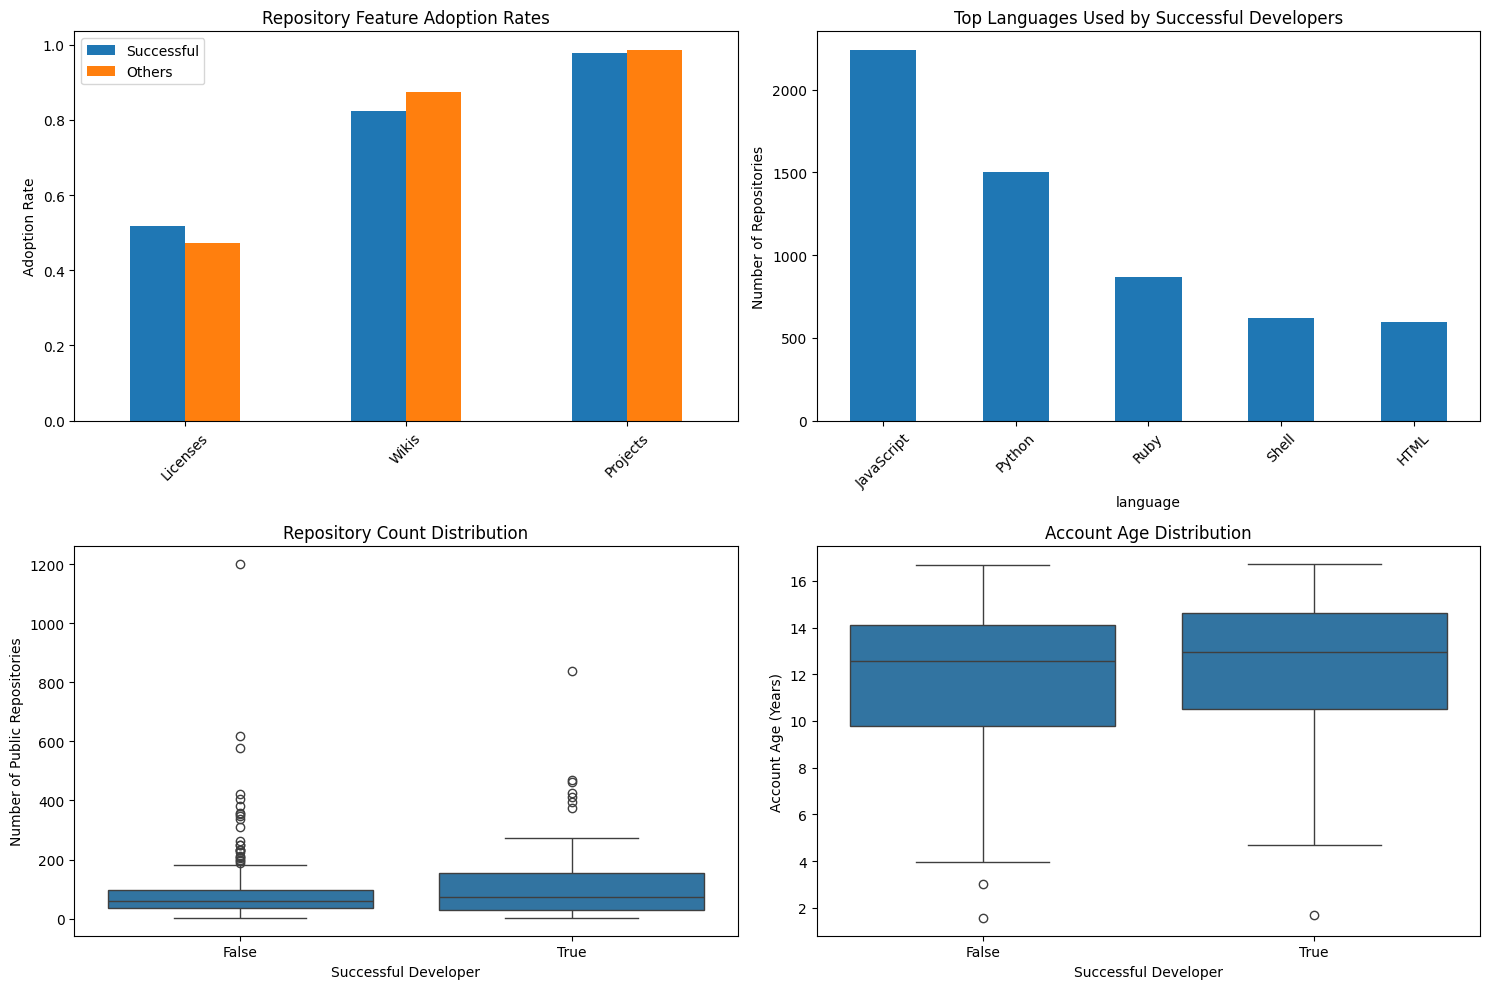


Actionable Recommendations for GitHub Developers:

1. Maintain more public repositories. Successful developers average 110.3 public repositories, compared to 90.6 for others.
2. Focus on high-impact languages. Top languages among successful developers are: JavaScript, Python, Ruby, Shell, HTML


In [4]:
# Generate and print recommendations
recommendations = analyze_and_recommend()
print("\nActionable Recommendations for GitHub Developers:\n")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")